<a href="https://colab.research.google.com/github/jasminjahanpuspo/Bangla_Taka_Classification-/blob/main/BM_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 📦 Install libraries
!pip install transformers
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor

In [12]:
import os
import numpy as np
import time

In [3]:
# 2. 🎨 Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:
# 3. 📂 Load your datasets
train_dir = "/content/drive/MyDrive/BM_aug/train"
val_dir = "/content/drive/MyDrive/BM_aug/val"
test_dir = "/content/drive/MyDrive/BM_aug/test"


train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

class_names = train_dataset.classes
num_classes = len(class_names)

In [10]:
# 4. 🧠 Load pretrained ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# 5. ⚙️ Define optimizer, loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [13]:
# 6. 🚀 Training Loop
num_epochs = 5  # start with 10 epochs first!


# Timer start
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # --- Logging ---
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}   | Val Accuracy: {val_accuracy*100:.2f}%\n")

# Timer end and total time taken
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time // 60:.0f} minutes and {total_training_time % 60:.0f} seconds")


Epoch 1/5
  Train Loss: 1.0256 | Train Accuracy: 72.94%
  Val Loss: 0.5850   | Val Accuracy: 92.93%

Epoch 2/5
  Train Loss: 0.3859 | Train Accuracy: 95.33%
  Val Loss: 0.2590   | Val Accuracy: 100.00%

Epoch 3/5
  Train Loss: 0.1897 | Train Accuracy: 99.93%
  Val Loss: 0.1553   | Val Accuracy: 100.00%

Epoch 4/5
  Train Loss: 0.1268 | Train Accuracy: 100.00%
  Val Loss: 0.1131   | Val Accuracy: 100.00%

Epoch 5/5
  Train Loss: 0.0977 | Train Accuracy: 100.00%
  Val Loss: 0.0913   | Val Accuracy: 100.00%

Total Training Time: 30 minutes and 51 seconds


In [29]:
# ✅ Test Accuracy Calculation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_accuracy = correct / total
print(f"\n✅ Test Accuracy: {test_accuracy*100:.2f}%")



✅ Test Accuracy: 99.08%


In [14]:
# ✅ Save model
torch.save(model.state_dict(), "vit_bangla_currency.pt")
print("Model saved as vit_bangla_currency.pt ✅")

Model saved as vit_bangla_currency.pt ✅


In [15]:
import matplotlib.pyplot as plt

# Assume you store these during training
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Inside training loop, right after calculating avg_train_loss and avg_val_loss
train_losses.append(avg_train_loss)
val_losses.append(avg_val_loss)
train_accuracies.append(train_accuracy)
val_accuracies.append(val_accuracy)


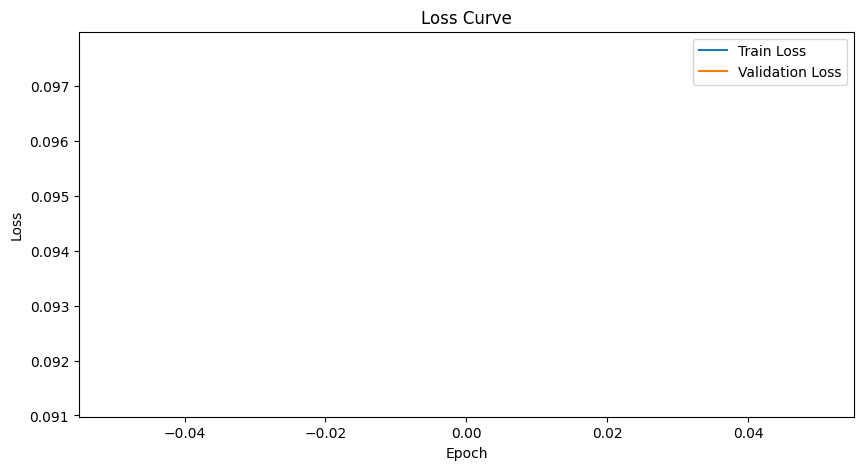

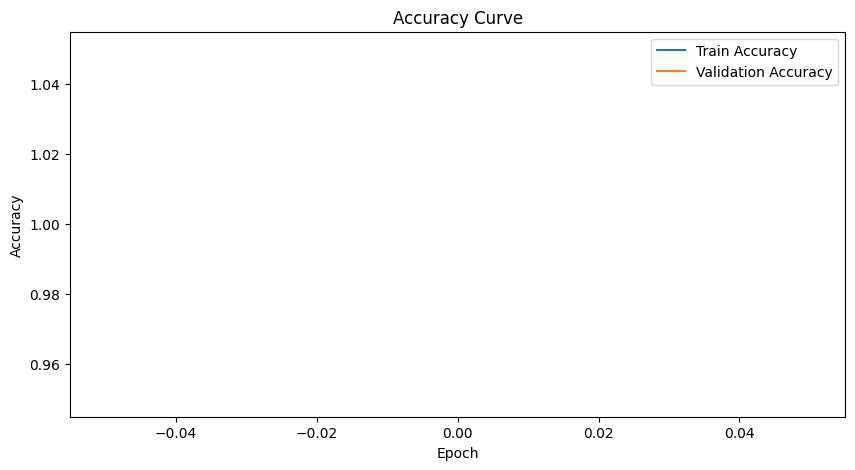

In [16]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
from sklearn.metrics import classification_report

# Assuming you already have all_preds and all_true from earlier
report = classification_report(all_true, all_preds, target_names=train_dataset.classes)
print("\n📋 Classification Report:\n")
print(report)



📋 Classification Report:

              precision    recall  f1-score   support

         10        1.00      0.97      0.99       118
        100        1.00      1.00      1.00        99
        1000       1.00      1.00      1.00        35
         20        1.00      1.00      1.00        20
         50        0.94      1.00      0.97        45
        500        1.00      1.00      1.00        10

    accuracy                           0.99       327
   macro avg       0.99      1.00      0.99       327
weighted avg       0.99      0.99      0.99       327



In [17]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


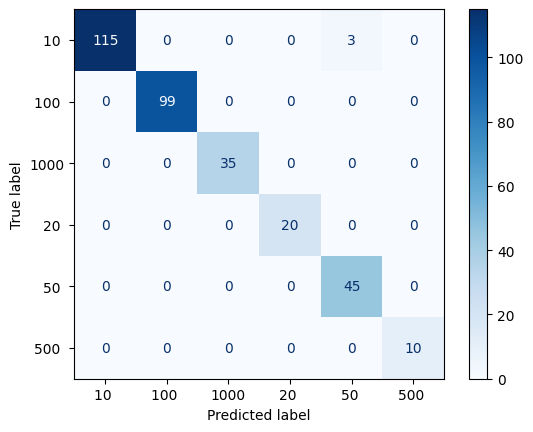

In [18]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.show()


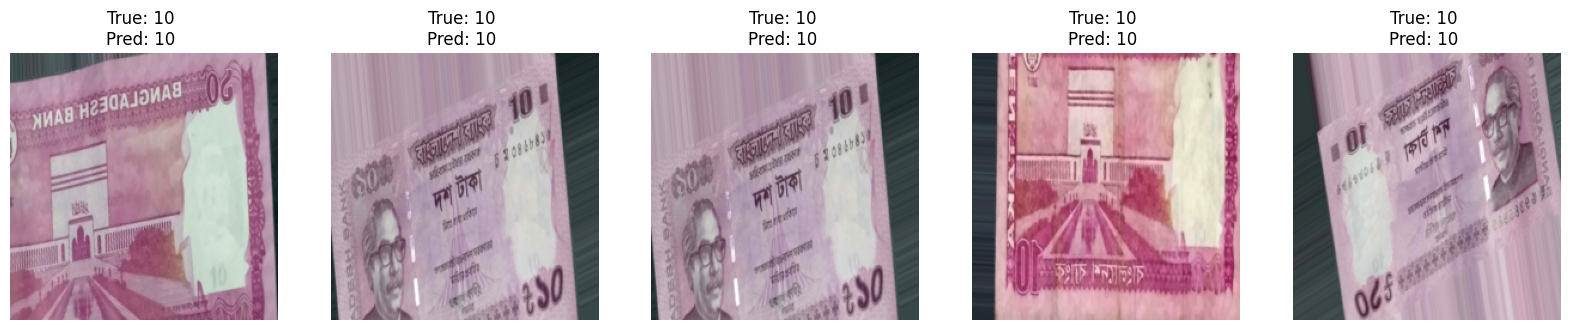

In [23]:
import random

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images).logits
_, preds = torch.max(outputs, 1)

# Show 5 random images
fig, axs = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    idx = random.randint(0, images.size(0)-1)
    img = images[idx].cpu().permute(1,2,0) * 0.5 + 0.5  # unnormalize
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
plt.show()


<ipython-input-24-9652ca249b2f>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_classes)


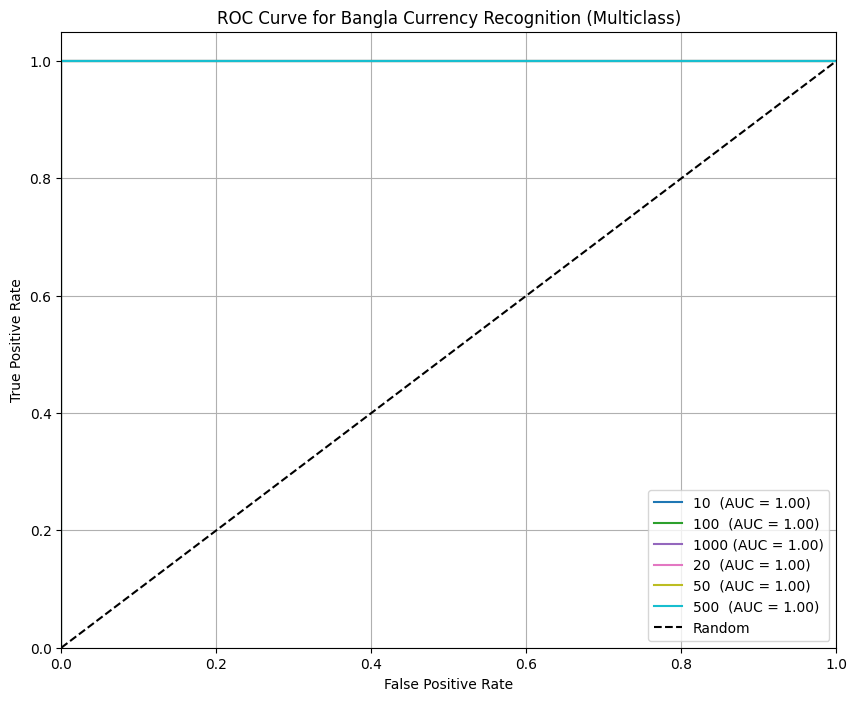

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Put model in eval mode
model.eval()

# ✅ Prepare test data and predictions
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ✅ Binarize labels for multiclass ROC
classes = train_dataset.classes  # 6 classes
n_classes = len(classes)
y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# ✅ Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Bangla Currency Recognition (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


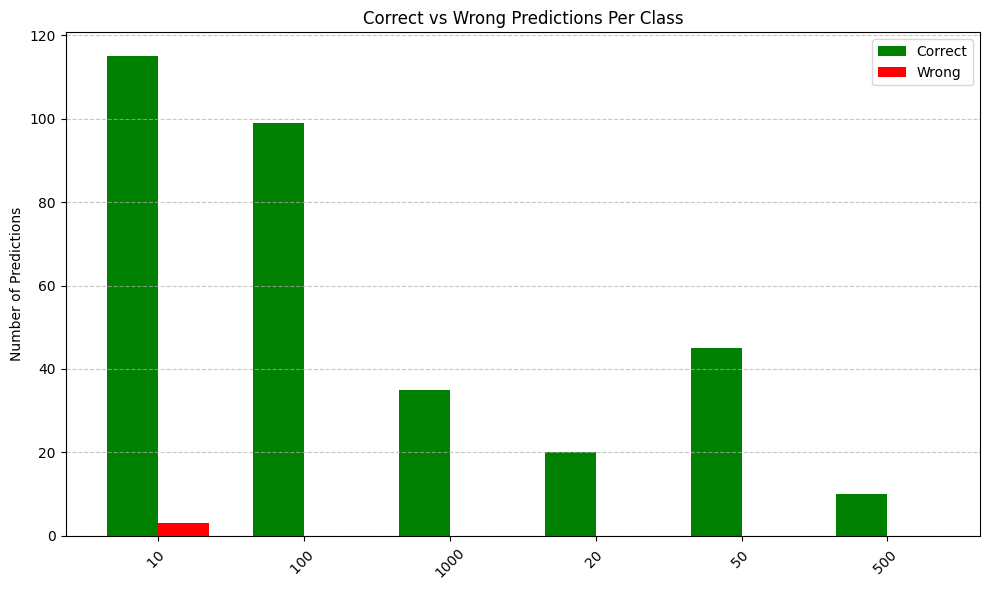

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Initialize counters
correct_counts = np.zeros(len(train_dataset.classes), dtype=int)
wrong_counts = np.zeros(len(train_dataset.classes), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = preds[i].item()
            if label == pred:
                correct_counts[label] += 1
            else:
                wrong_counts[label] += 1

# ✅ Class labels
class_names = train_dataset.classes
x = np.arange(len(class_names))

# ✅ Plot
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, correct_counts, width=bar_width, label='Correct', color='green')
plt.bar(x + bar_width/2, wrong_counts, width=bar_width, label='Wrong', color='red')

plt.xticks(x, class_names, rotation=45)
plt.ylabel('Number of Predictions')
plt.title('Correct vs Wrong Predictions Per Class')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [26]:
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())


In [27]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(all_true, all_preds)
print(f"Cohen's Kappa Score: {kappa:.4f}")


Cohen's Kappa Score: 0.9877


In [28]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_true, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.9878


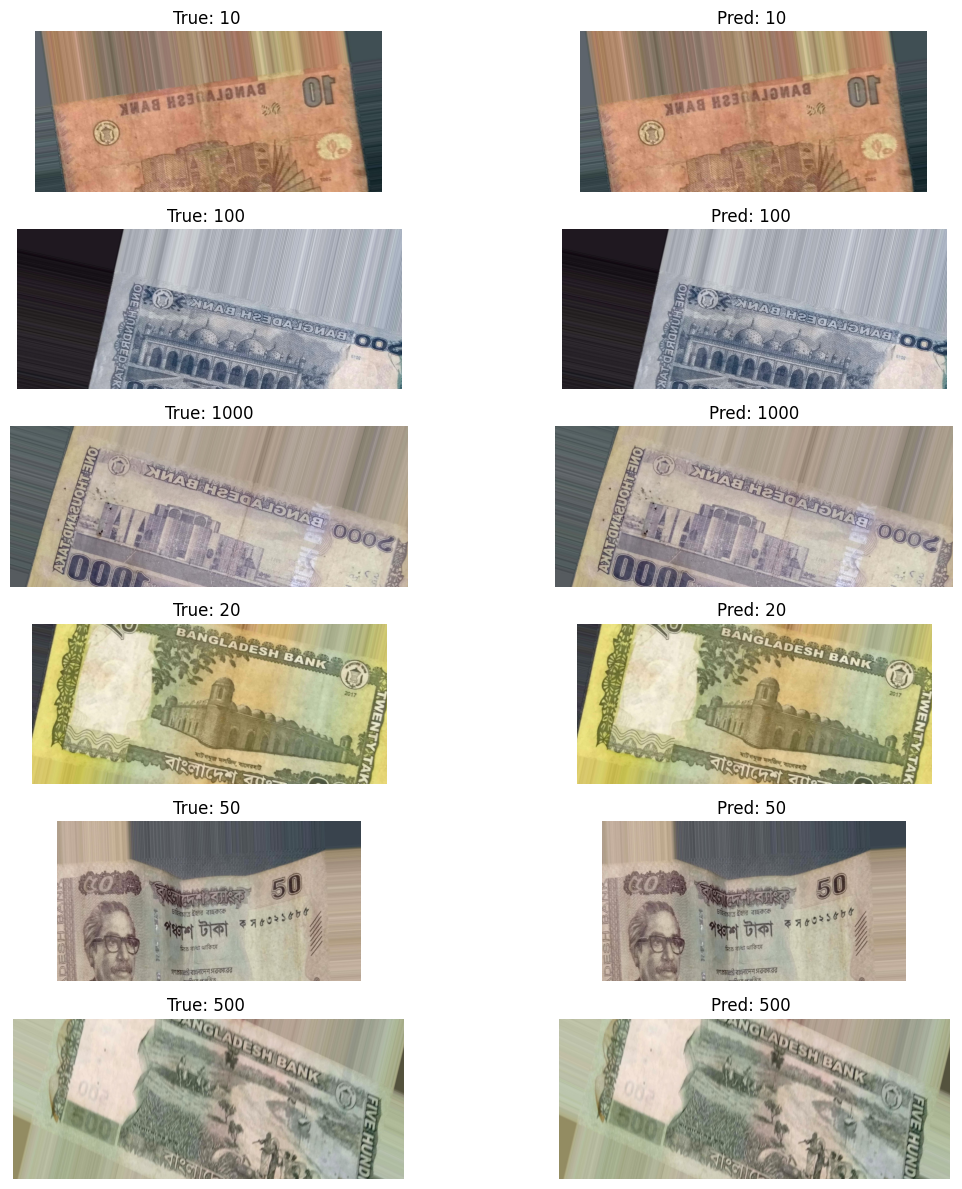

In [38]:
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from torchvision import transforms
from PIL import Image # Import the Image module

# ✅ Set model to evaluation mode
model.eval()

# Prepare a list of the class names from your train dataset
class_names = train_dataset.classes

# Plotting setup
plt.figure(figsize=(12, 12))

# Track how many images we have shown
images_shown = 0
num_classes = len(class_names)

# Define the path to your test set directory
test_dir = "/content/drive/MyDrive/BM_aug/test"

# Loop through each class and pick an image from the test set
for class_folder in class_names:
    # Get the full path to the class folder in the test set
    class_image_path = os.path.join(test_dir, class_folder)

    # List all files in the class folder and select the first image (you can modify this to random selection)
    class_images = os.listdir(class_image_path)
    image_path = os.path.join(class_image_path, class_images[0])  # Get the first image in the folder

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB') # Load image using PIL.Image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Apply the same transformation as the training data

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor).logits
        pred = torch.argmax(outputs, dim=1).item()

    # Plot the image with true and predicted labels
    plt.subplot(num_classes, 2, images_shown * 2 + 1)
    plt.imshow(image)
    plt.title(f"True: {class_folder}", fontsize=12)
    plt.axis('off')

    # Plot predicted label
    plt.subplot(num_classes, 2, images_shown * 2 + 2)
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred]}", fontsize=12)
    plt.axis('off')

    images_shown += 1

# Adjust the layout to ensure all images are nicely spaced
plt.tight_layout()
plt.show()

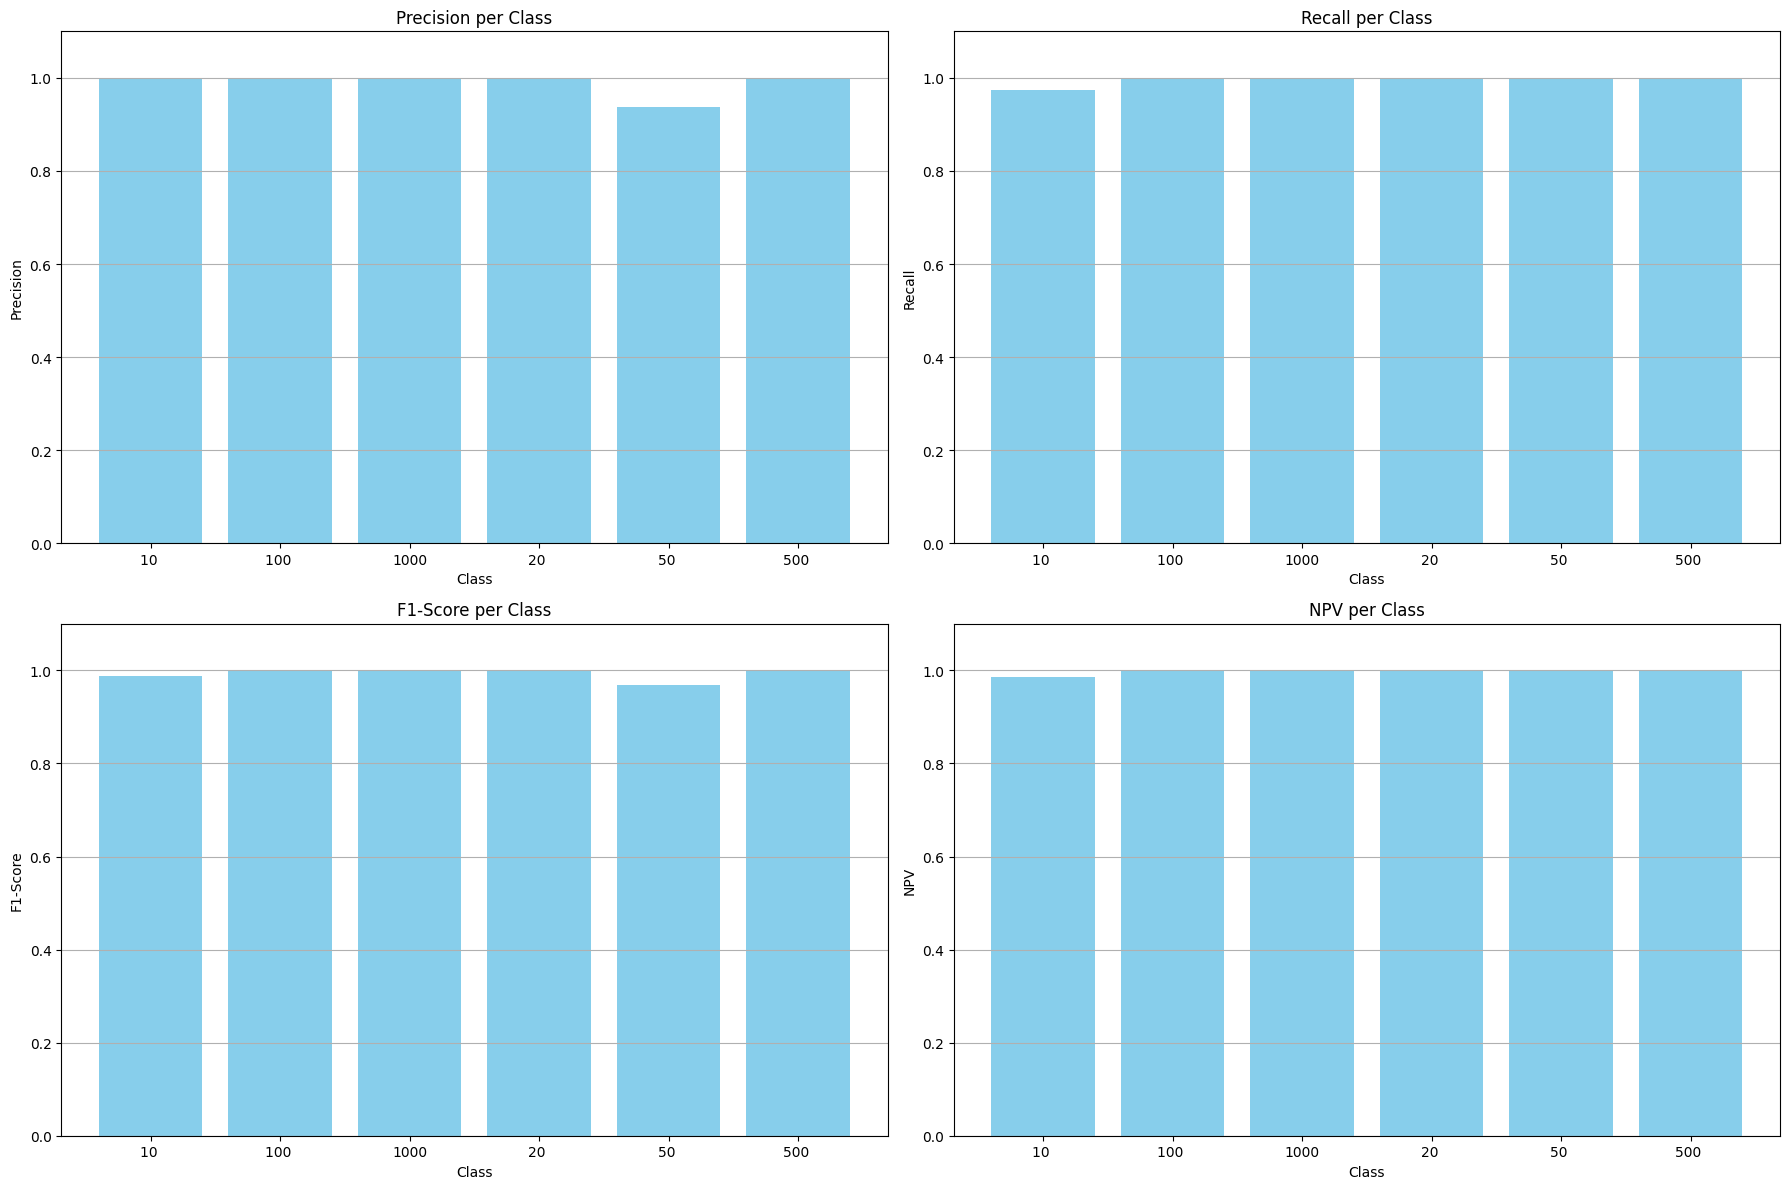

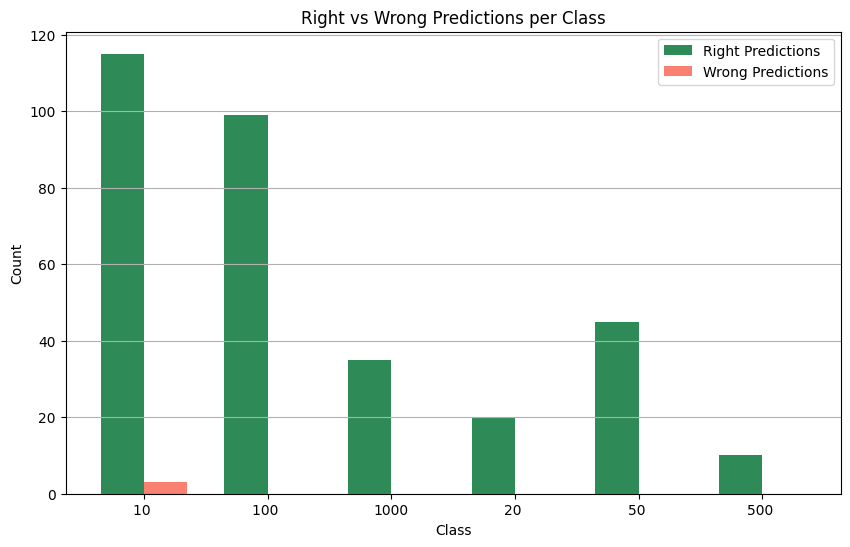

              precision    recall  f1-score   support

         10        1.00      0.97      0.99       118
        100        1.00      1.00      1.00        99
        1000       1.00      1.00      1.00        35
         20        1.00      1.00      1.00        20
         50        0.94      1.00      0.97        45
        500        1.00      1.00      1.00        10

    accuracy                           0.99       327
   macro avg       0.99      1.00      0.99       327
weighted avg       0.99      0.99      0.99       327



In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Step 2: Calculate Metrics
class_labels = test_dataset.classes  # Get class names automatically
num_classes = len(class_labels)

# Precision, Recall, F1 for each class
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Right and Wrong predictions per class
right_preds = cm.diagonal()
wrong_preds = cm.sum(axis=1) - right_preds

# NPV (Negative Predictive Value) Calculation per class
# NPV = TN / (TN + FN)
npv_per_class = []
for i in range(num_classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    npv = TN / (TN + FN) if (TN + FN) != 0 else 0
    npv_per_class.append(npv)

# Step 3: Plotting

# Plot Precision, Recall, F1-Score, NPV
metrics = ['Precision', 'Recall', 'F1-Score', 'NPV']
values = [precision_per_class, recall_per_class, f1_per_class, npv_per_class]

plt.figure(figsize=(18, 12))

for idx, metric in enumerate(metrics):
    plt.subplot(2, 2, idx + 1)
    plt.bar(class_labels, values[idx], color='skyblue')
    plt.ylim(0, 1.1)
    plt.title(f'{metric} per Class')
    plt.xlabel('Class')
    plt.ylabel(metric)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Plot Right vs Wrong Predictions
plt.figure(figsize=(10,6))
x = np.arange(num_classes)

bar_width = 0.35
plt.bar(x, right_preds, width=bar_width, label='Right Predictions', color='seagreen')
plt.bar(x + bar_width, wrong_preds, width=bar_width, label='Wrong Predictions', color='salmon')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Right vs Wrong Predictions per Class')
plt.xticks(x + bar_width/2, class_labels)
plt.legend()
plt.grid(axis='y')
plt.show()

# (Optional) Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))


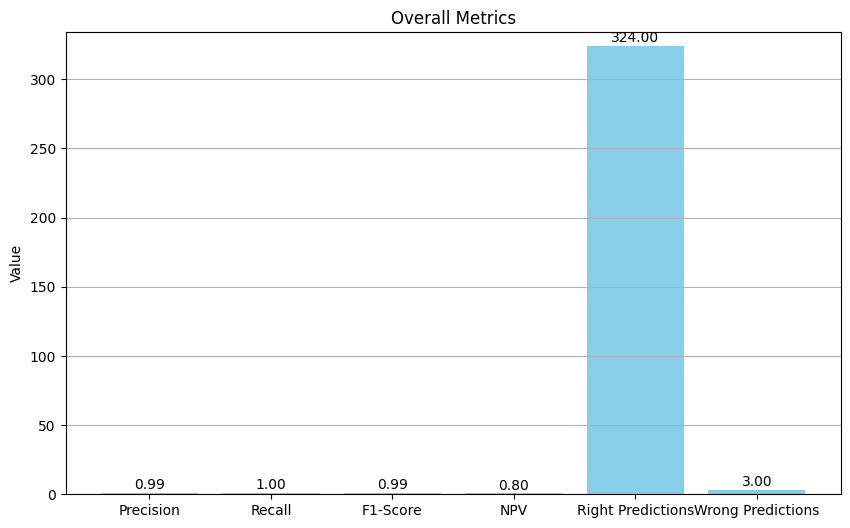

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Predict on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate overall metrics
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Right and wrong predictions (overall)
right = cm.diagonal().sum()
wrong = cm.sum() - right

# Calculate overall NPV (Negative Predictive Value)
# NPV = TN / (TN + FN)
TP = cm.diagonal().sum()
FP = cm.sum(axis=0) - cm.diagonal()
FN = cm.sum(axis=1) - cm.diagonal()
TN = cm.sum() - (FP + FN + TP)
npv = TN.sum() / (TN.sum() + FN.sum())

# Prepare for plotting
metrics = ['Precision', 'Recall', 'F1-Score', 'NPV', 'Right Predictions', 'Wrong Predictions']
values = [precision, recall, f1, npv, right, wrong]

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(metrics, values, color='skyblue')
plt.title('Overall Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values) + 10)  # Give little space
plt.grid(axis='y')

# Annotate values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()


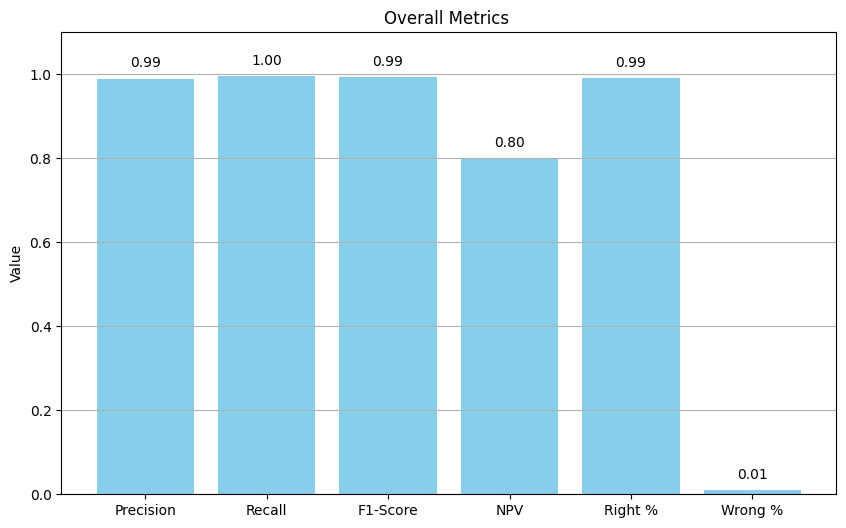

In [45]:
# Convert right/wrong to percentage
total = right + wrong
right_percent = right / total
wrong_percent = wrong / total

# Use all values in same 0–1 range
metrics = ['Precision', 'Recall', 'F1-Score', 'NPV', 'Right %', 'Wrong %']
values = [precision, recall, f1, npv, right_percent, wrong_percent]

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(metrics, values, color='skyblue')
plt.title('Overall Metrics ')
plt.ylabel('Value')
plt.ylim(0, 1.1)
plt.grid(axis='y')

# Annotate values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


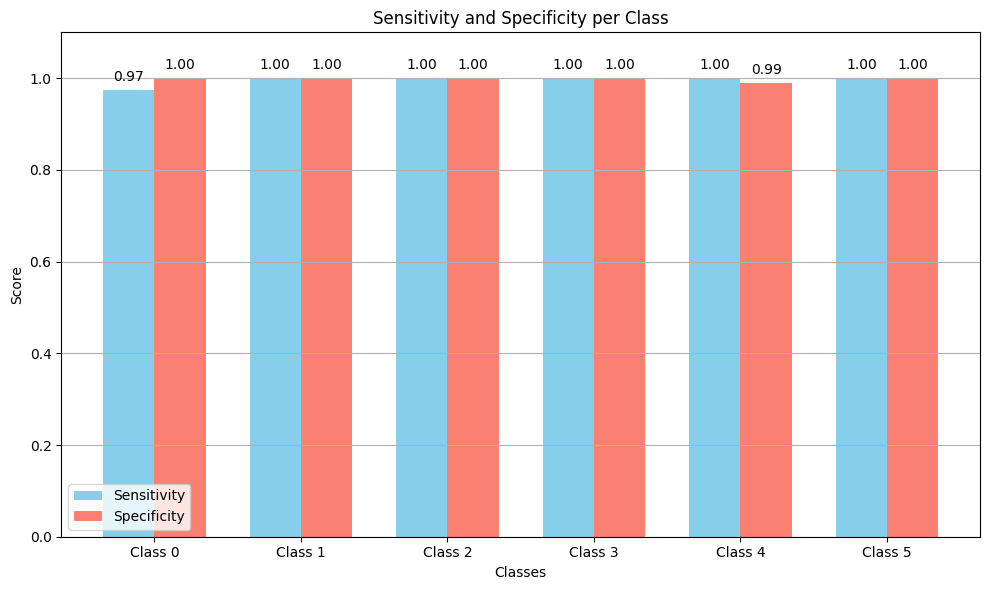

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Replace with your actual values
# y_true = [...]
# y_pred = [...]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]

# Compute sensitivity and specificity per class
sensitivities = []
specificities = []

for i in range(num_classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Plot
x_labels = [f"Class {i}" for i in range(num_classes)]
x = np.arange(len(x_labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, sensitivities, width, label='Sensitivity', color='skyblue')
plt.bar(x + width/2, specificities, width, label='Specificity', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity per Class')
plt.xticks(x, x_labels)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')

# Annotate bars
for i in range(num_classes):
    plt.text(x[i] - width/2, sensitivities[i] + 0.02, f"{sensitivities[i]:.2f}", ha='center')
    plt.text(x[i] + width/2, specificities[i] + 0.02, f"{specificities[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()


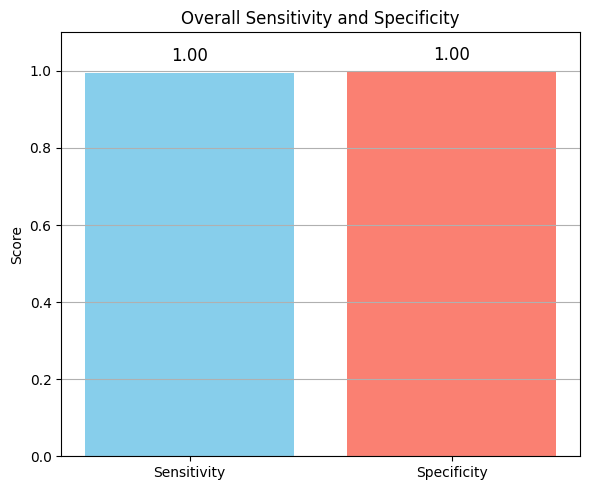

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Replace with your actual values
# y_true = [...]
# y_pred = [...]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

# Compute macro-averaged sensitivity and specificity
sensitivity = np.mean(TP / (TP + FN))
specificity = np.mean(TN / (TN + FP))

# Plot
metrics = ['Sensitivity', 'Specificity']
values = [sensitivity, specificity]

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'salmon'])
plt.ylim(0, 1.1)
plt.title('Overall Sensitivity and Specificity')
plt.ylabel('Score')
plt.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


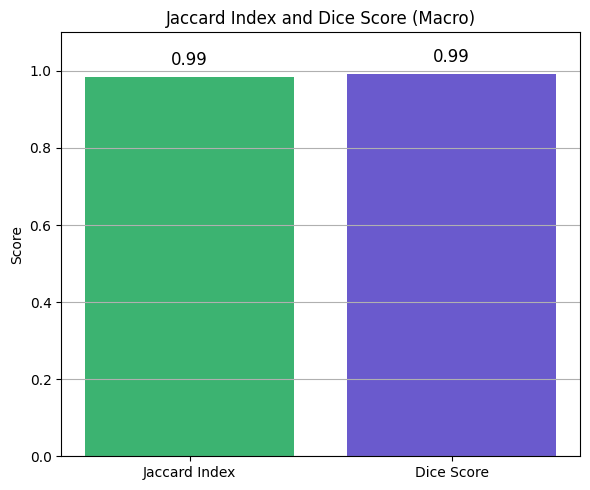

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score

# Example: Replace with your actual values
# y_true = [...]
# y_pred = [...]

# Compute Jaccard Index and Dice Score (macro average for multiclass)
jaccard = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
dice = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Plot
metrics = ['Jaccard Index', 'Dice Score']
values = [jaccard, dice]

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=['mediumseagreen', 'slateblue'])
plt.ylim(0, 1.1)
plt.title('Jaccard Index and Dice Score (Macro)')
plt.ylabel('Score')
plt.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()
